In [1]:
!pip install keras
!pip install sklearn
!pip install matplotlib
!pip install -U -q PyDrive

  Running setup.py bdist_wheel for sklearn ... - done
  Stored in directory: /content/.cache/pip/wheels/76/03/bb/589d421d27431bcd2c6da284d5f2286c8e3b2ea3cf1594c074
Successfully built sklearn


In [2]:
from keras import backend as K
K.clear_session()

Using TensorFlow backend.


In [0]:
from keras import backend as K
cfg = K.tf.ConfigProto()
cfg.gpu_options.allow_growth = True
K.set_session(K.tf.Session(config=cfg))

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
file_import = drive.CreateFile({'id':'1p1bsltfTcIrZ_kfE6kwGTPzcdXorHbb2'})
file_import.GetContentFile('colab_setup.py') 
from colab_setup import setup

setup(drive)

In [6]:
!ls

colab_setup.py			 roc_auc_callback.py	X_train.npy
custom_fast_text_embeddings.npy  sample_submission.csv	X_val.npy
datalab				 train_model.py		y_test.npy
fast_text_embeddings.npy	 X_submission.npy	y_train_full.npy
plot_history.py			 X_test.npy		y_train.npy
__pycache__			 X_train_full.npy	y_val.npy


In [0]:
import numpy as np
import os

from plot_history import plot_history
from roc_auc_callback import RocAucCallback
from train_model import train_with_cv, train_with_submitting, evaluate_on_test

from keras.models import Model
from keras.layers import *
from keras.layers.merge import concatenate

In [0]:
file_import = drive.CreateFile({'id':'15j1Nou6m5WNLejJQrUcty6U03xsIgIAI'})
file_import.GetContentFile('SelfAttention.py') 

from SelfAttention import SelfAttention

In [0]:
def one_by_one(filtersNumber, inputLayer, dropout = 0.2):
    one_by_one = Conv1D(filtersNumber, 1, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    one_by_one = BatchNormalization()(one_by_one)
    one_by_one = SpatialDropout1D(dropout)(one_by_one)
    
    return one_by_one

In [0]:
def yoon_kim_feature_extractor(filtersNumber, inputLayer):
    block_1_conv_1 = Conv1D(filtersNumber, 1, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm1 = BatchNormalization()(block_1_conv_1)
    block_1_max_pool1 = GlobalMaxPooling1D()(block_1_batchnorm1)

    block_1_conv_2 = Conv1D(filtersNumber, 2, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm2 = BatchNormalization()(block_1_conv_2)
    block_1_max_pool2 = GlobalMaxPooling1D()(block_1_batchnorm2)

    block_1_conv_3 = Conv1D(filtersNumber, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm3 = BatchNormalization()(block_1_conv_3)
    block_1_max_pool3 = GlobalMaxPooling1D()(block_1_batchnorm3)

    block_1_conv_4 = Conv1D(filtersNumber, 5, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm4 = BatchNormalization()(block_1_conv_4)
    block_1_max_pool4 = GlobalMaxPooling1D()(block_1_batchnorm4)

    block_1_features = concatenate([
        block_1_max_pool1, 
        block_1_max_pool2, 
        block_1_max_pool3, 
        block_1_max_pool4
    ])
    block_1_features = Dropout(0.2)(block_1_features)
    return block_1_features

In [0]:
def single_category_regressor(features, context, unitsNumber = 64):
    features = concatenate([features, context])
    
    dense_1 = Dense(unitsNumber, activation = 'elu')(features)
    dense_1_normalization = BatchNormalization()(dense_1)
    dense_1_dropout = Dropout(0.2)(dense_1_normalization)

    dense_2 = Dense(unitsNumber, activation = 'elu')(dense_1_dropout)
    dense_2_normalization = BatchNormalization()(dense_2)
    dense_2_dropout = Dropout(0.2)(dense_2_normalization)
    
    return Dense(1, activation='sigmoid')(dense_2_dropout)

In [12]:
maxWords = 30000
maxSequenceLengthInWords = 400
embeddingDimension = 300
filtersNumber = 300

input_layer = Input(shape=(maxSequenceLengthInWords,))

pretrained_embedding_layer = Embedding(
    maxWords, 
    output_dim=embeddingDimension, 
    input_length=maxSequenceLengthInWords,
    weights = [np.load('fast_text_embeddings.npy')],
    trainable = False
)(input_layer)
pretrained_embedding_layer = SpatialDropout1D(0.2)(pretrained_embedding_layer)

custom_embedding_layer = Embedding(
    maxWords, 
    output_dim=embeddingDimension, 
    input_length=maxSequenceLengthInWords,
    weights = [np.load('custom_fast_text_embeddings.npy')],
    trainable = False
)(input_layer)
custom_embedding_layer = SpatialDropout1D(0.2)(custom_embedding_layer)

embedding = Average()([pretrained_embedding_layer, custom_embedding_layer])
embedding_dropout = SpatialDropout1D(0.2)(embedding)

embedding_dropout = SelfAttention()(embedding_dropout)

features_1 = one_by_one(filtersNumber, embedding_dropout)
features_2 = one_by_one(filtersNumber, features_1)
features_3 = one_by_one(filtersNumber, features_2)

features = yoon_kim_feature_extractor(filtersNumber, features_3)


dense_1 = Dense(256, activation = 'elu')(features)
dense_1_normalization = BatchNormalization()(dense_1)
dense_1_dropout = Dropout(0.2)(dense_1_normalization)

dense_2 = Dense(256, activation = 'elu')(dense_1_dropout)
dense_2_normalization = BatchNormalization()(dense_2)
dense_2_dropout = Dropout(0.2)(dense_2_normalization)

output_layer = Dense(6, activation='sigmoid')(dense_2_dropout)

single_category_layer = concatenate([
    single_category_regressor(features, dense_2_dropout, 64),
    single_category_regressor(features, dense_2_dropout, 64),
    single_category_regressor(features, dense_2_dropout, 64),
    single_category_regressor(features, dense_2_dropout, 64),
    single_category_regressor(features, dense_2_dropout, 64),
    single_category_regressor(features, dense_2_dropout, 64),
])

output_layer = average([output_layer, single_category_layer])

model = Model(inputs=[input_layer], outputs=[output_layer])
            
model.summary()

model.compile(
    loss='binary_crossentropy', 
    optimizer='Adam',
    metrics=['accuracy']
)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 400)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 400, 300)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
spatial_dr

In [13]:
history = train_with_cv(model, batchSize=32, rocEvery = 2)

Train on 102124 samples, validate on 25532 samples
Epoch 1/32
 20352/102124 [====>.........................] - ETA: 8:52 - loss: 0.2059 - acc: 0.8875

 55232/102124 [===============>..............] - ETA: 4:58 - loss: 0.1270 - acc: 0.9405

 89888/102124 [=========================>....] - ETA: 1:18 - loss: 0.1059 - acc: 0.9536

102124/102124 [==============================] - 694s 7ms/step - loss: 0.1018 - acc: 0.9561 - val_loss: 0.1536 - val_acc: 0.9639
Epoch 2/32
  8320/102124 [=>............................] - ETA: 9:33 - loss: 0.0670 - acc: 0.9761

 43680/102124 [===========>..................] - ETA: 6:24 - loss: 0.0631 - acc: 0.9778

 78336/102124 [======================>.......] - ETA: 2:33 - loss: 0.0614 - acc: 0.9783

102124/102124 [==============================] - 692s 7ms/step - loss: 0.0608 - acc: 0.9784 - val_loss: 0.0584 - val_acc: 0.9784
roc-auc: 0.9771 - roc-auc_val: 0.9754                                                                                                    
Epoch 3/32
  2336/102124 [..............................] - ETA: 10:15 - loss: 0.0621 - acc: 0.9760

 36096/102124 [=========>....................] - ETA: 6:43 - loss: 0.0554 - acc: 0.9795

 70560/102124 [===================>..........] - ETA: 3:19 - loss: 0.0548 - acc: 0.9798

102124/102124 [==============================] - 686s 7ms/step - loss: 0.0546 - acc: 0.9799 - val_loss: 0.0450 - val_acc: 0.9827
Epoch 4/32
  1056/102124 [..............................] - ETA: 10:22 - loss: 0.0610 - acc: 0.9760

 37408/102124 [=========>....................] - ETA: 7:09 - loss: 0.0527 - acc: 0.9803

 72448/102124 [====================>.........] - ETA: 3:09 - loss: 0.0521 - acc: 0.9804

102124/102124 [==============================] - 685s 7ms/step - loss: 0.0516 - acc: 0.9806 - val_loss: 0.0468 - val_acc: 0.9820
roc-auc: 0.9847 - roc-auc_val: 0.9826                                                                                                    
Epoch 5/32
  1280/102124 [..............................] - ETA: 12:27 - loss: 0.0424 - acc: 0.9840

 36032/102124 [=========>....................] - ETA: 7:06 - loss: 0.0504 - acc: 0.9812

 79616/102124 [======================>.......] - ETA: 2:28 - loss: 0.0490 - acc: 0.9814

102124/102124 [==============================] - 725s 7ms/step - loss: 0.0491 - acc: 0.9813 - val_loss: 0.0524 - val_acc: 0.9817

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0003298769879620522.
Epoch 6/32
  3392/102124 [..............................] - ETA: 10:11 - loss: 0.0455 - acc: 0.9824

 36288/102124 [=========>....................] - ETA: 6:49 - loss: 0.0480 - acc: 0.9814

 72960/102124 [====================>.........] - ETA: 2:59 - loss: 0.0475 - acc: 0.9817

102124/102124 [==============================] - 686s 7ms/step - loss: 0.0476 - acc: 0.9817 - val_loss: 0.1006 - val_acc: 0.9744
roc-auc: 0.9796 - roc-auc_val: 0.9734                                                                                                    
Epoch 7/32
  1248/102124 [..............................] - ETA: 11:53 - loss: 0.0357 - acc: 0.9844

 35648/102124 [=========>....................] - ETA: 7:27 - loss: 0.0464 - acc: 0.9818

 69184/102124 [===================>..........] - ETA: 3:34 - loss: 0.0464 - acc: 0.9820

102124/102124 [==============================] - 695s 7ms/step - loss: 0.0467 - acc: 0.9819 - val_loss: 0.0452 - val_acc: 0.9828
Epoch 8/32
   320/102124 [..............................] - ETA: 10:25 - loss: 0.0294 - acc: 0.9891

 33280/102124 [========>.....................] - ETA: 7:04 - loss: 0.0449 - acc: 0.9826

 68160/102124 [===================>..........] - ETA: 3:37 - loss: 0.0457 - acc: 0.9821

102124/102124 [==============================] - 697s 7ms/step - loss: 0.0457 - acc: 0.9821 - val_loss: 0.0443 - val_acc: 0.9831
roc-auc: 0.9896 - roc-auc_val: 0.9857                                                                                                    
Epoch 9/32
    64/102124 [..............................]

 33824/102124 [========>.....................] - ETA: 7:11 - loss: 0.0439 - acc: 0.9828

 67968/102124 [==================>...........] - ETA: 3:33 - loss: 0.0444 - acc: 0.9825

102124/102124 [==============================] - 675s 7ms/step - loss: 0.0443 - acc: 0.9825 - val_loss: 0.0480 - val_acc: 0.9822


Epoch 10/32
 31808/102124 [========>.....................] - ETA: 7:12 - loss: 0.0444 - acc: 0.9822

 66592/102124 [==================>...........] - ETA: 3:46 - loss: 0.0442 - acc: 0.9826

100448/102124 [============================>.] - ETA: 10s - loss: 0.0438 - acc: 0.9828

102124/102124 [==============================] - 691s 7ms/step - loss: 0.0439 - acc: 0.9828 - val_loss: 0.0567 - val_acc: 0.9817
roc-auc: 0.9867 - roc-auc_val: 0.9783                                                                                                    
Epoch 11/32
  7584/102124 [=>............................] - ETA: 9:53 - loss: 0.0435 - acc: 0.9825

 40096/102124 [==========>...................] - ETA: 6:28 - loss: 0.0433 - acc: 0.9830

 74048/102124 [====================>.........] - ETA: 2:54 - loss: 0.0429 - acc: 0.9831

102124/102124 [==============================] - 692s 7ms/step - loss: 0.0432 - acc: 0.9830 - val_loss: 0.0415 - val_acc: 0.9841
Epoch 12/32
  2528/102124 [..............................] - ETA: 10:30 - loss: 0.0466 - acc: 0.9823

 37248/102124 [=========>....................] - ETA: 6:55 - loss: 0.0425 - acc: 0.9831

 72416/102124 [====================>.........] - ETA: 3:16 - loss: 0.0427 - acc: 0.9830

102124/102124 [==============================] - 704s 7ms/step - loss: 0.0426 - acc: 0.9831 - val_loss: 0.0418 - val_acc: 0.9840
roc-auc: 0.9922 - roc-auc_val: 0.9873                                                                                                    
Epoch 13/32
   896/102124 [..............................] - ETA: 10:20 - loss: 0.0406 - acc: 0.9846

 39072/102124 [==========>...................] - ETA: 6:36 - loss: 0.0409 - acc: 0.9839

 73216/102124 [====================>.........] - ETA: 3:04 - loss: 0.0417 - acc: 0.9836

102124/102124 [==============================] - 700s 7ms/step - loss: 0.0421 - acc: 0.9834 - val_loss: 0.0410 - val_acc: 0.9843
Epoch 14/32
  2080/102124 [..............................] - ETA: 12:27 - loss: 0.0398 - acc: 0.9845

 37600/102124 [==========>...................] - ETA: 7:12 - loss: 0.0420 - acc: 0.9831

 70976/102124 [===================>..........] - ETA: 3:21 - loss: 0.0417 - acc: 0.9835

102124/102124 [==============================] - 692s 7ms/step - loss: 0.0417 - acc: 0.9835 - val_loss: 0.0409 - val_acc: 0.9843
roc-auc: 0.9926 - roc-auc_val: 0.9871                                                                                                    
Epoch 15/32
   480/102124 [..............................] - ETA: 10:32 - loss: 0.0408 - acc: 0.9840

 37184/102124 [=========>....................] - ETA: 6:48 - loss: 0.0410 - acc: 0.9837

 72864/102124 [====================>.........] - ETA: 3:07 - loss: 0.0412 - acc: 0.9838

102124/102124 [==============================] - 694s 7ms/step - loss: 0.0414 - acc: 0.9836 - val_loss: 0.0404 - val_acc: 0.9845
Epoch 16/32
  1632/102124 [..............................] - ETA: 10:15 - loss: 0.0373 - acc: 0.9852

 36032/102124 [=========>....................] - ETA: 7:37 - loss: 0.0405 - acc: 0.9836

 69696/102124 [===================>..........] - ETA: 3:34 - loss: 0.0405 - acc: 0.9838

102124/102124 [==============================] - 703s 7ms/step - loss: 0.0406 - acc: 0.9838 - val_loss: 0.0406 - val_acc: 0.9844
roc-auc: 0.993 - roc-auc_val: 0.9869                                                                                                    
Epoch 17/32
   256/102124 [..............................] - ETA: 10:39 - loss: 0.0294 - acc: 0.9896

 34976/102124 [=========>....................] - ETA: 7:09 - loss: 0.0402 - acc: 0.9840

 69024/102124 [===================>..........] - ETA: 3:34 - loss: 0.0398 - acc: 0.9840

102124/102124 [==============================] - 705s 7ms/step - loss: 0.0402 - acc: 0.9839 - val_loss: 0.0412 - val_acc: 0.9840

Epoch 00017: ReduceLROnPlateau reducing learning rate to 9.473228419665247e-05.
Epoch 18/32
   160/102124 [..............................] - ETA: 11:56 - loss: 0.0585 - acc: 0.9750

 34336/102124 [=========>....................] - ETA: 7:34 - loss: 0.0394 - acc: 0.9839

 69248/102124 [===================>..........] - ETA: 3:31 - loss: 0.0398 - acc: 0.9839

102124/102124 [==============================] - 688s 7ms/step - loss: 0.0400 - acc: 0.9838 - val_loss: 0.0405 - val_acc: 0.9845
roc-auc: 0.9937 - roc-auc_val: 0.9873                                                                                                    
Epoch 19/32
   256/102124 [..............................] - ETA: 10:29 - loss: 0.0315 - acc: 0.9857

 34080/102124 [=========>....................] - ETA: 6:55 - loss: 0.0388 - acc: 0.9840

 68256/102124 [===================>..........] - ETA: 3:35 - loss: 0.0395 - acc: 0.9839

102048/102124 [============================>.] - ETA: 0s - loss: 0.0395 - acc: 0.9841

102124/102124 [==============================] - 693s 7ms/step - loss: 0.0395 - acc: 0.9841 - val_loss: 0.0402 - val_acc: 0.9844
Epoch 20/32
 13600/102124 [==>...........................] - ETA: 10:57 - loss: 0.0384 - acc: 0.9846

 48544/102124 [=============>................] - ETA: 6:05 - loss: 0.0387 - acc: 0.9845

 82816/102124 [=======================>......] - ETA: 2:09 - loss: 0.0392 - acc: 0.9843

102124/102124 [==============================] - 720s 7ms/step - loss: 0.0394 - acc: 0.9842 - val_loss: 0.0402 - val_acc: 0.9845
roc-auc: 0.9939 - roc-auc_val: 0.9874                                                                                                    
Epoch 21/32
  3392/102124 [..............................] - ETA: 12:28 - loss: 0.0403 - acc: 0.9840

 38304/102124 [==========>...................] - ETA: 7:08 - loss: 0.0396 - acc: 0.9842

 70688/102124 [===================>..........] - ETA: 3:23 - loss: 0.0394 - acc: 0.9841

102124/102124 [==============================] - 690s 7ms/step - loss: 0.0392 - acc: 0.9842 - val_loss: 0.0402 - val_acc: 0.9845
Epoch 22/32
   960/102124 [..............................] - ETA: 10:18 - loss: 0.0456 - acc: 0.9832

 34560/102124 [=========>....................] - ETA: 6:55 - loss: 0.0397 - acc: 0.9841

 68096/102124 [===================>..........] - ETA: 3:36 - loss: 0.0391 - acc: 0.9843

102112/102124 [============================>.] - ETA: 0s - loss: 0.0391 - acc: 0.9842

102124/102124 [==============================] - 692s 7ms/step - loss: 0.0391 - acc: 0.9842 - val_loss: 0.0403 - val_acc: 0.9844
roc-auc: 0.9941 - roc-auc_val: 0.9877                                                                                                    
Epoch 23/32
  8256/102124 [=>............................] - ETA: 9:48 - loss: 0.0395 - acc: 0.9843

 42560/102124 [===========>..................] - ETA: 6:07 - loss: 0.0382 - acc: 0.9845

 76320/102124 [=====================>........] - ETA: 2:39 - loss: 0.0384 - acc: 0.9844

102124/102124 [==============================] - 687s 7ms/step - loss: 0.0385 - acc: 0.9844 - val_loss: 0.0416 - val_acc: 0.9841
Epoch 24/32
  2912/102124 [..............................] - ETA: 10:22 - loss: 0.0353 - acc: 0.9861

 37536/102124 [==========>...................] - ETA: 6:57 - loss: 0.0372 - acc: 0.9852

 72576/102124 [====================>.........] - ETA: 3:13 - loss: 0.0378 - acc: 0.9847

102124/102124 [==============================] - 709s 7ms/step - loss: 0.0380 - acc: 0.9847 - val_loss: 0.0402 - val_acc: 0.9845
roc-auc: 0.9946 - roc-auc_val: 0.9874                                                                                                    
Epoch 25/32
   768/102124 [..............................] - ETA: 10:41 - loss: 0.0373 - acc: 0.9848

 36608/102124 [=========>....................] - ETA: 7:00 - loss: 0.0373 - acc: 0.9848

 71456/102124 [===================>..........] - ETA: 3:26 - loss: 0.0378 - acc: 0.9845

102124/102124 [==============================] - 714s 7ms/step - loss: 0.0382 - acc: 0.9844 - val_loss: 0.0405 - val_acc: 0.9845
Epoch 26/32
  1056/102124 [..............................] - ETA: 10:23 - loss: 0.0349 - acc: 0.9848

 33664/102124 [========>.....................] - ETA: 7:03 - loss: 0.0376 - acc: 0.9845

 67488/102124 [==================>...........] - ETA: 3:34 - loss: 0.0376 - acc: 0.9845

101152/102124 [============================>.] - ETA: 6s - loss: 0.0376 - acc: 0.9845

102124/102124 [==============================] - 674s 7ms/step - loss: 0.0376 - acc: 0.9845 - val_loss: 0.0406 - val_acc: 0.9843
roc-auc: 0.994 - roc-auc_val: 0.9865                                                                                                    
Epoch 27/32
  7840/102124 [=>............................] - ETA: 10:04 - loss: 0.0397 - acc: 0.9838

 41920/102124 [===========>..................] - ETA: 6:26 - loss: 0.0380 - acc: 0.9847

 76000/102124 [=====================>........] - ETA: 2:51 - loss: 0.0381 - acc: 0.9846

102124/102124 [==============================] - 704s 7ms/step - loss: 0.0379 - acc: 0.9846 - val_loss: 0.0403 - val_acc: 0.9844
Epoch 28/32
  2464/102124 [..............................] - ETA: 10:24 - loss: 0.0403 - acc: 0.9850

 37952/102124 [==========>...................] - ETA: 6:34 - loss: 0.0379 - acc: 0.9847

 72576/102124 [====================>.........] - ETA: 3:08 - loss: 0.0378 - acc: 0.9847

102124/102124 [==============================] - 698s 7ms/step - loss: 0.0376 - acc: 0.9847 - val_loss: 0.0405 - val_acc: 0.9845

Epoch 00028: ReduceLROnPlateau reducing learning rate to 3.0185510695446283e-05.
roc-auc: 0.9948 - roc-auc_val: 0.9868                                                                                                    
Epoch 29/32
   864/102124 [..............................] - ETA: 10:25 - loss: 0.0360 - acc: 0.9853

 34464/102124 [=========>....................] - ETA: 6:57 - loss: 0.0375 - acc: 0.9849

 68128/102124 [===================>..........] - ETA: 3:29 - loss: 0.0377 - acc: 0.9847

101504/102124 [============================>.] - ETA: 3s - loss: 0.0374 - acc: 0.9847

102124/102124 [==============================] - 671s 7ms/step - loss: 0.0375 - acc: 0.9846 - val_loss: 0.0408 - val_acc: 0.9843
Epoch 30/32
 12960/102124 [==>...........................] - ETA: 10:38 - loss: 0.0361 - acc: 0.9852

 46880/102124 [============>.................] - ETA: 6:00 - loss: 0.0369 - acc: 0.9850

 83904/102124 [=======================>......] - ETA: 1:59 - loss: 0.0371 - acc: 0.9848

102124/102124 [==============================] - 715s 7ms/step - loss: 0.0373 - acc: 0.9847 - val_loss: 0.0403 - val_acc: 0.9845
roc-auc: 0.9951 - roc-auc_val: 0.9868                                                                                                    
Epoch 31/32
  3840/102124 [>.............................] - ETA: 10:21 - loss: 0.0369 - acc: 0.9857

 37504/102124 [==========>...................] - ETA: 6:44 - loss: 0.0373 - acc: 0.9847

 70976/102124 [===================>..........] - ETA: 3:14 - loss: 0.0369 - acc: 0.9850

102124/102124 [==============================] - 691s 7ms/step - loss: 0.0372 - acc: 0.9847 - val_loss: 0.0406 - val_acc: 0.9844
Epoch 32/32
   928/102124 [..............................] - ETA: 10:39 - loss: 0.0331 - acc: 0.9872

 36928/102124 [=========>....................] - ETA: 7:01 - loss: 0.0376 - acc: 0.9846

 73056/102124 [====================>.........] - ETA: 3:12 - loss: 0.0371 - acc: 0.9848

102124/102124 [==============================] - 706s 7ms/step - loss: 0.0370 - acc: 0.9849 - val_loss: 0.0407 - val_acc: 0.9845
roc-auc: 0.9951 - roc-auc_val: 0.9869                                                                                                    


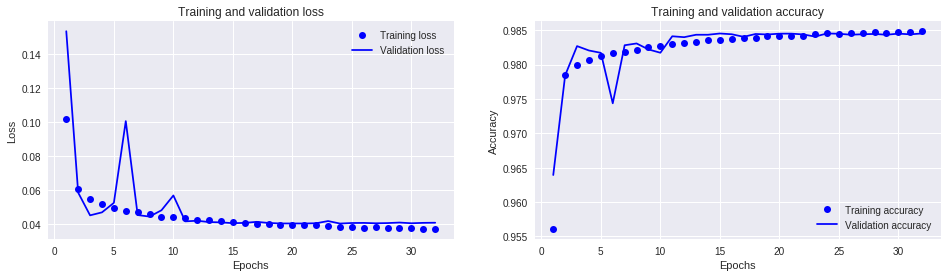

In [14]:
plot_history(history)

In [15]:
print(evaluate_on_test(model))

31915/31915 [==============================] - 56s 2ms/step
([0.03913720385787929, 0.9845527050937023], 0.9890625781772132)


In [13]:
history = train_with_cv(model, batchSize=64, rocEvery = 2)

Train on 102124 samples, validate on 25532 samples
Epoch 1/32
 42880/102124 [===========>..................] - ETA: 4:59 - loss: 0.1709 - acc: 0.9180

102124/102124 [==============================] - 543s 5ms/step - loss: 0.1149 - acc: 0.9503 - val_loss: 0.0666 - val_acc: 0.9793
Epoch 2/32
  5440/102124 [>.............................] - ETA: 7:51 - loss: 0.0704 - acc: 0.9755

102080/102124 [============================>.] - ETA: 0s - loss: 0.0644 - acc: 0.9774

102124/102124 [==============================] - 533s 5ms/step - loss: 0.0644 - acc: 0.9774 - val_loss: 0.2079 - val_acc: 0.9444
roc-auc: 0.9736 - roc-auc_val: 0.9714                                                                                                    
Epoch 3/32
 17408/102124 [====>.........................] - ETA: 6:51 - loss: 0.0584 - acc: 0.9792

102080/102124 [============================>.] - ETA: 0s - loss: 0.0574 - acc: 0.9794

102124/102124 [==============================] - 534s 5ms/step - loss: 0.0574 - acc: 0.9794 - val_loss: 0.3783 - val_acc: 0.8039

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0004061262006871402.
Epoch 4/32
 16064/102124 [===>..........................] - ETA: 7:00 - loss: 0.0543 - acc: 0.9800

102080/102124 [============================>.] - ETA: 0s - loss: 0.0523 - acc: 0.9807

102124/102124 [==============================] - 535s 5ms/step - loss: 0.0523 - acc: 0.9807 - val_loss: 0.0589 - val_acc: 0.9819
roc-auc: 0.981 - roc-auc_val: 0.9781                                                                                                    
Epoch 5/32
 17472/102124 [====>.........................] - ETA: 6:52 - loss: 0.0497 - acc: 0.9816

102080/102124 [============================>.] - ETA: 0s - loss: 0.0499 - acc: 0.9812

102124/102124 [==============================] - 535s 5ms/step - loss: 0.0499 - acc: 0.9812 - val_loss: 0.5417 - val_acc: 0.7125
Epoch 6/32
 20352/102124 [====>.........................] - ETA: 6:38 - loss: 0.0460 - acc: 0.9826

102080/102124 [============================>.] - ETA: 0s - loss: 0.0477 - acc: 0.9817

102124/102124 [==============================] - 535s 5ms/step - loss: 0.0477 - acc: 0.9817 - val_loss: 0.0450 - val_acc: 0.9835
roc-auc: 0.989 - roc-auc_val: 0.9847                                                                                                    
Epoch 7/32
 17472/102124 [====>.........................] - ETA: 6:52 - loss: 0.0486 - acc: 0.9816

102080/102124 [============================>.] - ETA: 0s - loss: 0.0465 - acc: 0.9822

102124/102124 [==============================] - 534s 5ms/step - loss: 0.0465 - acc: 0.9822 - val_loss: 0.0436 - val_acc: 0.9837
Epoch 8/32
 20352/102124 [====>.........................] - ETA: 6:36 - loss: 0.0445 - acc: 0.9826

102080/102124 [============================>.] - ETA: 0s - loss: 0.0450 - acc: 0.9826

102124/102124 [==============================] - 534s 5ms/step - loss: 0.0450 - acc: 0.9826 - val_loss: 0.0436 - val_acc: 0.9834
roc-auc: 0.9896 - roc-auc_val: 0.9858                                                                                                    
Epoch 9/32
 17408/102124 [====>.........................] - ETA: 6:53 - loss: 0.0427 - acc: 0.9835

102080/102124 [============================>.] - ETA: 0s - loss: 0.0441 - acc: 0.9826

102124/102124 [==============================] - 534s 5ms/step - loss: 0.0441 - acc: 0.9826 - val_loss: 0.0638 - val_acc: 0.9774
Epoch 10/32
 20288/102124 [====>.........................] - ETA: 6:38 - loss: 0.0431 - acc: 0.9832

102080/102124 [============================>.] - ETA: 0s - loss: 0.0431 - acc: 0.9832

102124/102124 [==============================] - 535s 5ms/step - loss: 0.0431 - acc: 0.9832 - val_loss: 0.0430 - val_acc: 0.9840
roc-auc: 0.99 - roc-auc_val: 0.9865                                                                                                    
Epoch 11/32
 17472/102124 [====>.........................] - ETA: 6:51 - loss: 0.0433 - acc: 0.9829

102080/102124 [============================>.] - ETA: 0s - loss: 0.0427 - acc: 0.9832

102124/102124 [==============================] - 534s 5ms/step - loss: 0.0427 - acc: 0.9832 - val_loss: 0.0457 - val_acc: 0.9828
Epoch 12/32
 20288/102124 [====>.........................] - ETA: 6:38 - loss: 0.0422 - acc: 0.9835

102080/102124 [============================>.] - ETA: 0s - loss: 0.0419 - acc: 0.9836

102124/102124 [==============================] - 534s 5ms/step - loss: 0.0419 - acc: 0.9836 - val_loss: 0.0419 - val_acc: 0.9842
roc-auc: 0.9923 - roc-auc_val: 0.9866                                                                                                    
Epoch 13/32
 17344/102124 [====>.........................] - ETA: 6:53 - loss: 0.0410 - acc: 0.9834

102080/102124 [============================>.] - ETA: 0s - loss: 0.0412 - acc: 0.9837

102124/102124 [==============================] - 535s 5ms/step - loss: 0.0412 - acc: 0.9837 - val_loss: 0.0443 - val_acc: 0.9835
Epoch 14/32
 20288/102124 [====>.........................] - ETA: 6:36 - loss: 0.0397 - acc: 0.9841

102080/102124 [============================>.] - ETA: 0s - loss: 0.0406 - acc: 0.9840

102124/102124 [==============================] - 533s 5ms/step - loss: 0.0406 - acc: 0.9840 - val_loss: 0.0418 - val_acc: 0.9842
roc-auc: 0.9928 - roc-auc_val: 0.9862                                                                                                    
Epoch 15/32
 17344/102124 [====>.........................] - ETA: 6:52 - loss: 0.0393 - acc: 0.9846

102080/102124 [============================>.] - ETA: 0s - loss: 0.0403 - acc: 0.9839

102124/102124 [==============================] - 533s 5ms/step - loss: 0.0403 - acc: 0.9839 - val_loss: 0.0410 - val_acc: 0.9845
Epoch 16/32
 20288/102124 [====>.........................] - ETA: 6:38 - loss: 0.0383 - acc: 0.9846

102080/102124 [============================>.] - ETA: 0s - loss: 0.0397 - acc: 0.9841

102124/102124 [==============================] - 534s 5ms/step - loss: 0.0397 - acc: 0.9841 - val_loss: 0.0425 - val_acc: 0.9838
roc-auc: 0.9924 - roc-auc_val: 0.9865                                                                                                    
Epoch 17/32
 17344/102124 [====>.........................] - ETA: 6:52 - loss: 0.0385 - acc: 0.9846

102080/102124 [============================>.] - ETA: 0s - loss: 0.0394 - acc: 0.9842

102124/102124 [==============================] - 534s 5ms/step - loss: 0.0394 - acc: 0.9842 - val_loss: 0.0424 - val_acc: 0.9841

Epoch 00017: ReduceLROnPlateau reducing learning rate to 9.473228419665247e-05.
Epoch 18/32
 16064/102124 [===>..........................] - ETA: 6:59 - loss: 0.0377 - acc: 0.9850

102080/102124 [============================>.] - ETA: 0s - loss: 0.0386 - acc: 0.9844

102124/102124 [==============================] - 534s 5ms/step - loss: 0.0386 - acc: 0.9844 - val_loss: 0.0480 - val_acc: 0.9819
roc-auc: 0.9913 - roc-auc_val: 0.9833                                                                                                    
Epoch 19/32
 17344/102124 [====>.........................] - ETA: 6:50 - loss: 0.0380 - acc: 0.9841

102080/102124 [============================>.] - ETA: 0s - loss: 0.0385 - acc: 0.9844

102124/102124 [==============================] - 529s 5ms/step - loss: 0.0384 - acc: 0.9844 - val_loss: 0.0406 - val_acc: 0.9845
Epoch 20/32
 20288/102124 [====>.........................] - ETA: 6:35 - loss: 0.0383 - acc: 0.9846

102080/102124 [============================>.] - ETA: 0s - loss: 0.0382 - acc: 0.9845

102124/102124 [==============================] - 532s 5ms/step - loss: 0.0382 - acc: 0.9845 - val_loss: 0.0413 - val_acc: 0.9844
roc-auc: 0.994 - roc-auc_val: 0.9868                                                                                                    
Epoch 21/32
 17408/102124 [====>.........................] - ETA: 6:53 - loss: 0.0386 - acc: 0.9842

102080/102124 [============================>.] - ETA: 0s - loss: 0.0380 - acc: 0.9847

102124/102124 [==============================] - 535s 5ms/step - loss: 0.0380 - acc: 0.9847 - val_loss: 0.0595 - val_acc: 0.9825
Epoch 22/32
 20288/102124 [====>.........................] - ETA: 6:39 - loss: 0.0377 - acc: 0.9847

102080/102124 [============================>.] - ETA: 0s - loss: 0.0375 - acc: 0.9849

102124/102124 [==============================] - 533s 5ms/step - loss: 0.0375 - acc: 0.9849 - val_loss: 0.0406 - val_acc: 0.9844
roc-auc: 0.9948 - roc-auc_val: 0.9873                                                                                                    
Epoch 23/32
 17344/102124 [====>.........................] - ETA: 6:52 - loss: 0.0373 - acc: 0.9851

102080/102124 [============================>.] - ETA: 0s - loss: 0.0372 - acc: 0.9849

102124/102124 [==============================] - 534s 5ms/step - loss: 0.0372 - acc: 0.9849 - val_loss: 0.0408 - val_acc: 0.9844
Epoch 24/32
 20288/102124 [====>.........................] - ETA: 6:38 - loss: 0.0369 - acc: 0.9848

102080/102124 [============================>.] - ETA: 0s - loss: 0.0371 - acc: 0.9849

102124/102124 [==============================] - 534s 5ms/step - loss: 0.0371 - acc: 0.9849 - val_loss: 0.0419 - val_acc: 0.9841
roc-auc: 0.9944 - roc-auc_val: 0.9866                                                                                                    
Epoch 25/32
 17344/102124 [====>.........................] - ETA: 6:51 - loss: 0.0367 - acc: 0.9850

102080/102124 [============================>.] - ETA: 0s - loss: 0.0370 - acc: 0.9850

102124/102124 [==============================] - 533s 5ms/step - loss: 0.0370 - acc: 0.9850 - val_loss: 0.0411 - val_acc: 0.9843
Epoch 26/32
 20288/102124 [====>.........................] - ETA: 6:38 - loss: 0.0353 - acc: 0.9858

102080/102124 [============================>.] - ETA: 0s - loss: 0.0368 - acc: 0.9848

102124/102124 [==============================] - 533s 5ms/step - loss: 0.0368 - acc: 0.9848 - val_loss: 0.0420 - val_acc: 0.9842
roc-auc: 0.9944 - roc-auc_val: 0.9861                                                                                                    
Epoch 27/32
 17344/102124 [====>.........................] - ETA: 6:52 - loss: 0.0367 - acc: 0.9846

102080/102124 [============================>.] - ETA: 0s - loss: 0.0362 - acc: 0.9850

102124/102124 [==============================] - 531s 5ms/step - loss: 0.0362 - acc: 0.9850 - val_loss: 0.0412 - val_acc: 0.9844
Epoch 28/32
 20288/102124 [====>.........................] - ETA: 6:36 - loss: 0.0356 - acc: 0.9853

102080/102124 [============================>.] - ETA: 0s - loss: 0.0360 - acc: 0.9853

102124/102124 [==============================] - 532s 5ms/step - loss: 0.0360 - acc: 0.9853 - val_loss: 0.0431 - val_acc: 0.9840

Epoch 00028: ReduceLROnPlateau reducing learning rate to 3.0185510695446283e-05.
roc-auc: 0.9943 - roc-auc_val: 0.9852                                                                                                    
Epoch 29/32
 11840/102124 [==>...........................] - ETA: 7:16 - loss: 0.0362 - acc: 0.9847

102080/102124 [============================>.] - ETA: 0s - loss: 0.0357 - acc: 0.9852

102124/102124 [==============================] - 527s 5ms/step - loss: 0.0357 - acc: 0.9852 - val_loss: 0.0415 - val_acc: 0.9843
Epoch 30/32
 20288/102124 [====>.........................] - ETA: 6:32 - loss: 0.0352 - acc: 0.9854

102080/102124 [============================>.] - ETA: 0s - loss: 0.0359 - acc: 0.9851

102124/102124 [==============================] - 529s 5ms/step - loss: 0.0359 - acc: 0.9851 - val_loss: 0.0415 - val_acc: 0.9843
roc-auc: 0.995 - roc-auc_val: 0.9856                                                                                                    
Epoch 31/32
 17408/102124 [====>.........................] - ETA: 6:49 - loss: 0.0359 - acc: 0.9850

102080/102124 [============================>.] - ETA: 0s - loss: 0.0356 - acc: 0.9853

102124/102124 [==============================] - 533s 5ms/step - loss: 0.0356 - acc: 0.9853 - val_loss: 0.0415 - val_acc: 0.9843
Epoch 32/32
 20288/102124 [====>.........................] - ETA: 6:38 - loss: 0.0363 - acc: 0.9852

102080/102124 [============================>.] - ETA: 0s - loss: 0.0354 - acc: 0.9853

102124/102124 [==============================] - 535s 5ms/step - loss: 0.0354 - acc: 0.9853 - val_loss: 0.0416 - val_acc: 0.9843
roc-auc: 0.9954 - roc-auc_val: 0.9861                                                                                                    


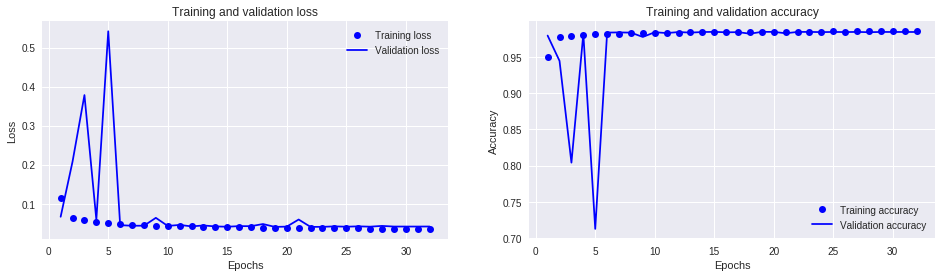

In [15]:
plot_history(history)

In [14]:
print(evaluate_on_test(model))

31915/31915 [==============================] - 53s 2ms/step
([0.03900999152548781, 0.9848973709700642], 0.9898779485205149)
